# Exercise 2


In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare

## Part 1

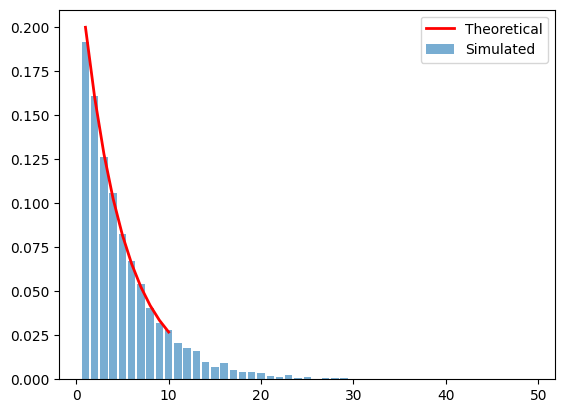

p=0.2: Chi-squared statistic = 8.4772, p-value = 0.5823


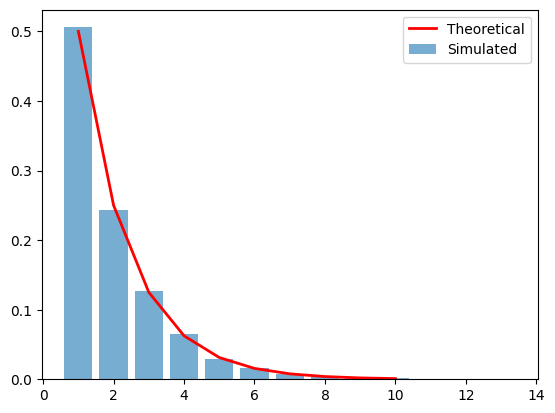

p=0.5: Chi-squared statistic = 6.6730, p-value = 0.7559


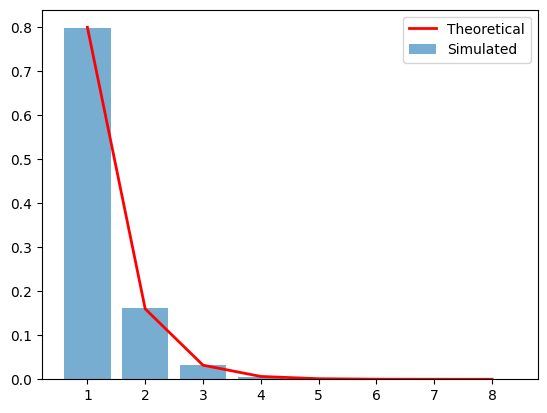

p=0.8: Chi-squared statistic = 17.4583, p-value = 0.0257


In [154]:
def simulate_geometric(n, p):
    # draw samples and get empirical counts
    samples = np.random.geometric(p, size=n)
    vals, counts = np.unique(samples, return_counts=True)

    max_k = min(vals.max(), 10)
    obs = [np.sum(samples == k) for k in range(1, max_k+1)]
    exp = [n * ((1-p)**(k-1) * p) for k in range(1, max_k+1)]

    obs_tail = n - sum(obs)
    exp_tail = n * (1-p)**max_k
    obs.append(obs_tail)
    exp.append(exp_tail)

    chi2_stat, p_val = chisquare(obs, f_exp=exp)

    # plot simulated vs theoretical
    plt.figure()
    plt.bar(vals, counts/n, alpha=0.6, label='Simulated')
    theos = [(1-p)**(k-1)*p for k in range(1, max_k+1)]
    plt.plot(range(1, max_k+1), theos, 'r-', lw=2, label='Theoretical')
    plt.legend()
    plt.show()

    return chi2_stat, p_val

n = 10000
for p in [0.2, 0.5, 0.8]:
    chi2, p_chi = simulate_geometric(n, p)
    print(f"p={p}: Chi-squared statistic = {chi2:.4f}, p-value = {p_chi:.4f}")

## Part 2

In [155]:
# probabilities
values = np.arange(1, 7)
probs = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])
cum = np.cumsum(probs)
n = 10000

# a) Crude method
def sample_crude(n):
    u = np.random.rand(n)
    # inverse transform
    return values[np.searchsorted(cum, u)]


In [156]:
# b) Rejection method
M = probs.max()
def sample_rejection(n):
    samples = []
    while len(samples) < n:
        x = np.random.choice(values)
        if np.random.rand() < probs[x-1]/M:
            samples.append(x)
    return np.array(samples)

In [157]:
# c) Alias method setup
def create_alias(probs):
    n = len(probs)
    q = probs * n
    alias = np.zeros(n, dtype=int)
    small = [i for i, qi in enumerate(q) if qi < 1]
    large = [i for i, qi in enumerate(q) if qi >= 1]
    while small and large:
        s = small.pop()
        l = large.pop()
        alias[s] = l
        q[l] = q[l] - (1 - q[s])
        if q[l] < 1:
            small.append(l)
        else:
            large.append(l)
    return q, alias
q, alias = create_alias(probs)
def sample_alias(n):
    i = np.random.randint(0, len(probs), size=n)
    u = np.random.rand(n)
    return np.where(u < q[i], values[i], values[alias[i]])

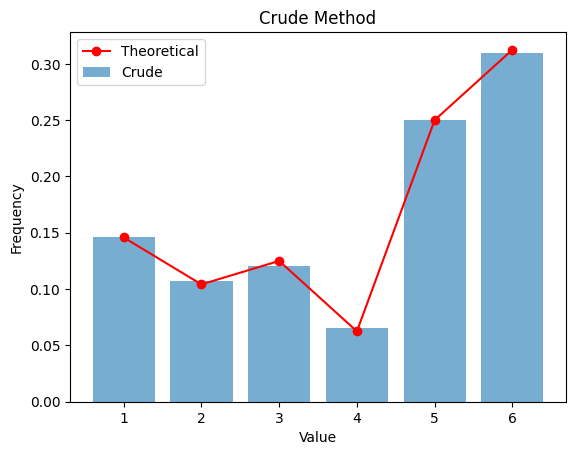

Crude: Chi2=3.91, p-value=0.563


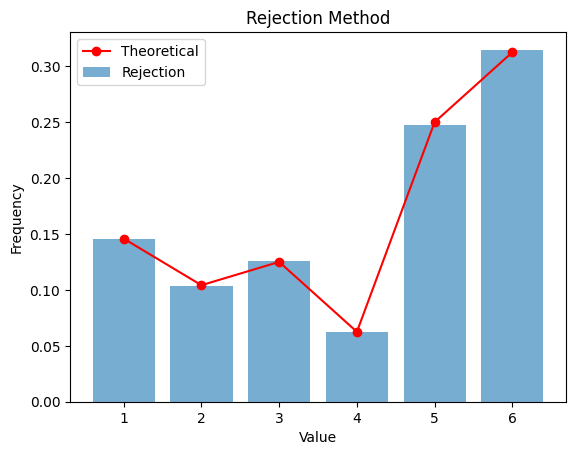

Rejection: Chi2=0.55, p-value=0.990


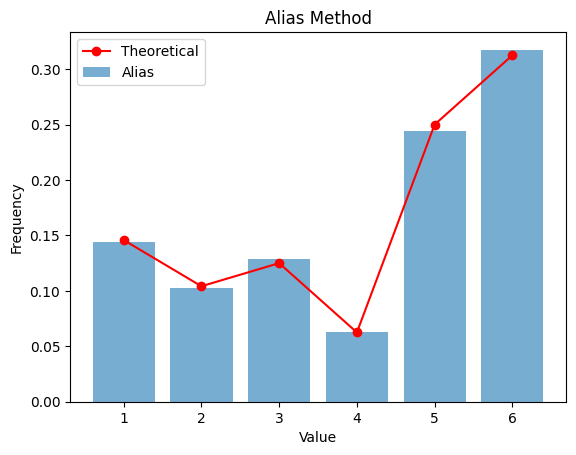

Alias: Chi2=3.59, p-value=0.609


In [158]:
# simulate and compare
methods = {'Crude': sample_crude, 'Rejection': sample_rejection, 'Alias': sample_alias}
results = {}
for name, func in methods.items():

    samp = func(n)

    vals, cnts = np.unique(samp, return_counts=True)
    results[name] = (cnts/n)
    # chi-square
    obs = cnts
    exp = n * probs
    chi2_stat, p_val = chisquare(obs, f_exp=exp)
    # plot
    plt.figure()
    plt.bar(values, cnts/n, alpha=0.6, label=name)
    plt.plot(values, probs, 'ro-', label='Theoretical')
    plt.title(f'{name} Method')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    print(f'{name}: Chi2={chi2_stat:.2f}, p-value={p_val:.3f}')

## Part 3
- **Crude**: simple, O(log K) per sample, accurate but slower for large K.
- **Rejection**: potentially unbounded runtime, best when max p small.
- **Alias**: O(1) per sample after O(K) setup, ideal for many samples.


## Part 4

**Sampling Method Comparison & Recommendations**

- **Alias Method**  
  - **Pros:** \(O(1)\) per draw after \(O(K)\) setup; blazing-fast for large \(N\).  
  - **Cons:** Upfront table construction; extra memory; more code.

- **Inverse Transform**  
  - **Pros:** Simple; exact; no rejects.  
  - **Cons:** \(O(\log K)\) per draw (CDF lookup), slower as \(K\) grows.

- **Rejection Sampling**  
  - **Pros:** No preprocessing; works when CDF inversion is hard.  
  - **Cons:** Unbounded runtime; inefficient if acceptance rate is low.

**When to Use**  
- **Few samples / small \(K\):** Inverse Transform  
- **Many samples / fixed discrete distribution:** Alias Method  
- **Complex or continuous targets:** Rejection (or advanced accept–reject)  